# X Posts Sentiment Analysis


# Connect To Google Drive (Ignore this if you are working locally)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!unzip "drive/MyDrive/sentiment140.zip"

unzip:  cannot find or open drive/MyDrive/sentiment140.zip, drive/MyDrive/sentiment140.zip.zip or drive/MyDrive/sentiment140.zip.ZIP.


# Imports

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import warnings
warnings.filterwarnings('ignore')                              # Turn the warnings off.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Dataset

## Reading the dataset

In [17]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)
df.shape

(1600000, 6)

In [18]:
# choose the text and target columns only
data = df[[5, 0]]

In [19]:
print(data.shape)
display(data.head())

(1600000, 2)


,5,0
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [20]:
data = data.rename(columns={5: 'text', 0:'class'})
data.head()

,text,class
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [21]:
data['class'].value_counts()

,count
class,
0,800000
4,800000


In [22]:
data.isnull().sum()

,0
text,0
class,0


## Sampling (50,000 samples from each class)

In [23]:
n = data.loc[data['class']== 0] # negative samples
p = data.loc[data['class']== 4] # positive samples

n = n.sample(n=50000, random_state=2024)
p = p.sample(n=50000, random_state=2024)

# concatenating
data = pd.concat([n, p], ignore_index=True)

(100000, 2)
class
0    50000
4    50000
Name: count, dtype: int64


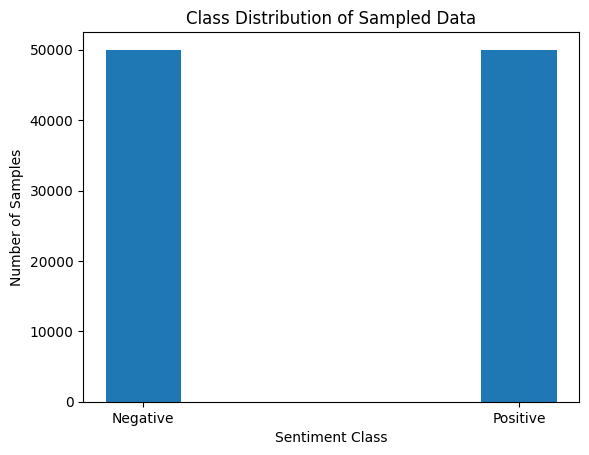

In [24]:
print(data.shape)
print(data['class'].value_counts())

class_dist = data['class'].value_counts()

plt.bar(class_dist.index, class_dist.values)
plt.xticks([0, 4], ['Negative', 'Positive'])
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution of Sampled Data')
plt.show()


# Data Pre-Processing

## Text cleaning

In [25]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower()

    # remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # remove mentions
    text = re.sub(r'@\w+', '', text)

    # remove # (we will keep the words)
    text = re.sub(r'#', '', text)

    # remove special characters, numbers, ...
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # remove whitespace
    # text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # remove english stop words
    words = [word for word in word_tokenize(text) if word not in stop_words] # word_tokenize(text) will generate a list of tokenized sample

    # lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)



data['text'] = data['text'].apply(clean_text)
data.head()

,text,class
0,next weekend miss,0
1,yep bedroom flat cost k dont enough penny one,0
2,happy father day daddy miss dad today year ago...,0
3,let get two since want doberman,0
4,parent well sister alone house lonely people b...,0


## Data splitting
> splitted data (tokenized and padded)

In [26]:
X = data['text']
y = data['class']
y = y.replace(4, 1)

# training (80%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=2024)

# validation (10%) and test (10%)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2024)

# tokenization
max_len = 50

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

max_words = len(tokenizer.word_index) + 1
print(max_words)

X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

# add padding
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_valid = pad_sequences(X_valid, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

51396


In [27]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(80000, 50) (80000,)
(10000, 50) (10000,)
(10000, 50) (10000,)


# Models

## Hyperparams
> can be modified

In [28]:
embedding_dim = 256
lstm_units = 256
dropout_rate = 0.5

lr = 0.001
optimizer = Adam(learning_rate=lr)
epochs = 20
batch_size = 64

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)



## 1 (simple model, 2 layers of LSTM)

In [29]:
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(LSTM(256, return_sequences=False))
model.add(Dropout(dropout_rate))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 256)             │      13,157,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,208,257 (54.20 MB)

 Trainable params: 14,208,257 (54.20 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:

filename = f"emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)


checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

emb256_lstm256_dropout0_5_lr0_001.keras
Epoch 1/20
1250/1250 - 925s - 740ms/step - accuracy: 0.8208 - loss: 0.4065 - val_accuracy: 0.7582 - val_loss: 0.5204
Epoch 2/20
1250/1250 - 963s - 770ms/step - accuracy: 0.8794 - loss: 0.2924 - val_accuracy: 0.7446 - val_loss: 0.5916
Epoch 3/20
1250/1250 - 919s - 735ms/step - accuracy: 0.9127 - loss: 0.2136 - val_accuracy: 0.7449 - val_loss: 0.7803
Epoch 4/20
1250/1250 - 903s - 722ms/step - accuracy: 0.9324 - loss: 0.1639 - val_accuracy: 0.7329 - val_loss: 0.8580


## 2 (Same but one dropout)

In [43]:
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(LSTM(256, return_sequences=False))
# model.add(Dropout(dropout_rate)) (will remove the dropout layer this time)

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()


filename = f"emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)


checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 256)             │      13,157,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,208,257 (54.20 MB)

 Trainable params: 14,208,257 (54.20 MB)

 Non-trainable params: 0 (0.00 B)

emb256_lstm256_dropout0_5_lr0_001.keras
Epoch 1/20
1250/1250 - 942s - 754ms/step - accuracy: 0.5294 - loss: 0.6854 - val_accuracy: 0.6738 - val_loss: 0.6189
Epoch 2/20
1250/1250 - 959s - 767ms/step - accuracy: 0.7261 - loss: 0.5652 - val_accuracy: 0.7481 - val_loss: 0.5181
Epoch 3/20


KeyboardInterrupt: 

## 3 (Bidirectional with one dropout)

In [ ]:

model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=False)))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"bidirectional_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


## 4 (same, with 2 dropouts)

In [ ]:

model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=False)))
model.add(Dropout(dropout_rate))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"bidirectional_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


## 5 (3 bidirectional layers)

In [ ]:

model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=False)))
model.add(Dropout(dropout_rate))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"bidirectional(3_layers)_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


## 6

In [ ]:

model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=False)))
# model.add(Dropout(dropout_rate))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"bidirectional(3_layers)_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


## 7

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(256, return_sequences=False)))
model.add(Dropout(dropout_rate))

# Additional dense layers
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Final dense layer for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"bidirectional(3_layers)_Dense(more_layers)_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

## 8 (GRU)

In [ ]:


model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(GRU(256, return_sequences=False))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

filename = f"gru_emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)

checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


## 9

In [ ]:

filename = f"emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)


checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

# Model Evaluation

### Loading the Best Model

In [34]:
from tensorflow.keras.models import load_model

model_filenames = [
    "emb256_lstm256_dropout0_5_lr0_001.keras",

    # "emb256_lstm256_dropout0_5_lr0_001.keras", # model 2 (one dropout)

    "bidirectional_emb256_lstm256_dropout0_5_lr0_001.keras",

    # "bidirectional_emb256_lstm256_dropout0_5_lr0_001.keras", # model 4 (with 2 dropouts)

    "bidirectional(3_layers)_emb256_lstm256_dropout0_5_lr0_001.keras",

    # "bidirectional(3_layers)_emb256_lstm256_dropout0_5_lr0_001.keras", # model 6

    "bidirectional(3_layers)_Dense(more_layers)_emb300_lstm256_dropout0_5_lr0_001.keras",
    "gru_emb300_lstm256_dropout0_5_lr0_001.keras",
    "emb256_lstm256_dropout0_6_lr0_001.keras",

]

best_model_metrics = None
best_model_filename = None

for filename in model_filenames:
    model = load_model(filename)

    eval_metrics = model.evaluate(X_test, y_test)
    print(f"Evaluation Metrics for model {filename}: {eval_metrics}")

    # Store the best model based on accuracy
    if best_model_metrics is None or eval_metrics[1] > best_model_metrics[1]:
        best_model_metrics = eval_metrics
        best_model_filename = filename

313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 109ms/step - accuracy: 0.7667 - loss: 0.4996
Evaluation Metrics for model emb256_lstm256_dropout0_5_lr0_001.keras: [0.5057934522628784, 0.7620999813079834]
Best model: emb256_lstm256_dropout0_5_lr0_001.keras with metrics: [0.5057934522628784, 0.7620999813079834]


### The best model

In [36]:
test_loss, test_accuracy = best_model_metrics
print(f"Best model: {best_model_filename}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Load the best model for predictions and classification report
best_model = load_model(best_model_filename)

Best model: emb256_lstm256_dropout0_5_lr0_001.keras
Test Loss: 0.5058
Test Accuracy: 0.7621


### Classification Report

In [37]:
y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step


In [39]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.78      0.75      0.76      5146
    Positive       0.74      0.78      0.76      4854

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



### Confusion Matrix

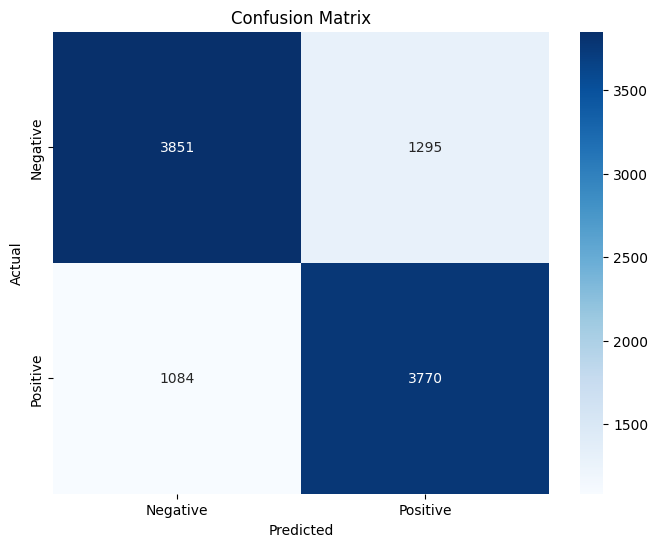

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


### Performance Metrics

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7621
Precision: 0.7443
Recall: 0.7767
F1 Score: 0.7602
